In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import configparser
from deap import creator, base, tools, algorithms

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
sys.path.append('../../src/')
import apdft
from apdft.calculator.mrcc import MrccCalculator
import apdft.physics as ap

In [3]:
def get_modepn(coordinates, fn):
    #return np.zeros(len(coordinates))
    density = MrccCalculator._parse_densityfile(fn)
    modepns = []
    for site in coordinates:
        ds = np.linalg.norm(density[:, :3] - site* ( 1 / 0.52917721067), axis=1)
        
        modepns.append(np.sum(density[:, 3] * density[:, 4] / ds))
    return modepns
def read_meta(basepath):
    nuclear_charges, coordinates = apdft.read_xyz('%s/inp.xyz' % basepath)
    config = configparser.ConfigParser()
    config.read('%s/apdft.conf' % basepath)
    includeonly = [int(_) for _ in config['apdft']['apdft_includeonly'].strip('[]').split(', ')]
    return nuclear_charges, coordinates, includeonly
def read_coefficients(basepath, nuclear_charges, coordinates, includeonly):
    N = len(includeonly)
    
    coefficients = np.zeros((1 + N*2 + N * (N - 1), N))
    
    # order 0
    pos = 0
    coefficients[pos, :] = get_modepn(coordinates[includeonly], '%s/QM/order-0/site-all-cc/DENSITY' % basepath)
    pos += 1
    
    # order 1
    for site in includeonly:
        coefficients[pos, :] = get_modepn(coordinates[includeonly], '%s/QM/order-1/site-%d-up/DENSITY' % (basepath,site))
        coefficients[pos+1, :] = get_modepn(coordinates[includeonly], '%s/QM/order-1/site-%d-dn/DENSITY' % (basepath,site))
        pos += 2
    
    # order 2
    for site_i in includeonly:
        for site_j in includeonly:
            if site_j <= site_i:
                continue
            
            coefficients[pos, :] = get_modepn(coordinates[includeonly], '%s/QM/order-2/site-%d-%d-up/DENSITY' % (basepath,site_i, site_j))
            coefficients[pos+1, :] = get_modepn(coordinates[includeonly], '%s/QM/order-2/site-%d-%d-dn/DENSITY' % (basepath,site_i, site_j))
            pos += 2
    
    return coefficients

basepath = 'data/coronene-dimer/mrcc-monomer-fast'
nuclear_charges_part, coordinates_part, includeonly_part = read_meta(basepath)
coefficients_part = read_coefficients(basepath, nuclear_charges_part, coordinates_part, includeonly_part)
#coefficients_part = np.load('%s/coefficients.npy' % basepath)
basepath = 'data/coronene-dimer/mrcc-fast'
nuclear_charges_whole, coordinates_whole, includeonly_whole = read_meta(basepath)
coefficients_whole = read_coefficients(basepath, nuclear_charges_whole, coordinates_whole, includeonly_whole)
#coefficients_whole = np.load('%s/coefficients.npy' % basepath)

In [4]:
delta = 0.05
(1/(2*delta**2))/2/3, (1/(delta**2))/2/3, 2 * (200/6.), (400/6.)
1 / (2 * 0.05) / np.math.factorial(1)

10.0

In [5]:
def predict_part(includeonly, coefficients, deltaZ):
    N = len(includeonly)
    delta = 0.05
    
    # build alphas
    alphas = np.zeros((1 + N*2 + N * (N - 1)))
    
    # order 0
    alphas[0] = 1
    # order 1
    for siteidx in range(N):
        alphas[1 + siteidx*2] += 0.5*1/(2*delta) * deltaZ[siteidx]
        alphas[1 + siteidx*2+1] -= 0.5*1/(2*delta) * deltaZ[siteidx]
    
    # order 2
    pos = 1 + N*2 - 2
    for siteidx_i in range(N):
        for siteidx_j in range(siteidx_i, N):
            if siteidx_i != siteidx_j:
                pos += 2
            if deltaZ[siteidx_j] == 0 or deltaZ[siteidx_i] == 0:
                continue
            if includeonly[siteidx_j] > includeonly[siteidx_i]:
                prefactor = ((1/(2*delta**2))/2/3) * deltaZ[siteidx_i]*deltaZ[siteidx_j]
                alphas[pos] += prefactor
                alphas[pos+1] += prefactor
                alphas[0] += 2*prefactor
                alphas[1 + siteidx_i*2] -= prefactor
                alphas[1 + siteidx_i*2+1] -= prefactor
                alphas[1 + siteidx_j*2] -= prefactor
                alphas[1 + siteidx_j*2+1] -= prefactor
            if includeonly[siteidx_j] == includeonly[siteidx_i]:
                prefactor = ((1/(delta**2))/2/3) * deltaZ[siteidx_i]*deltaZ[siteidx_j]
                alphas[0] -= 2*prefactor
                alphas[1 + siteidx_i*2] += prefactor
                alphas[1 + siteidx_j*2+1] += prefactor
    
    # calculate energy
    return np.sum(np.multiply(np.outer(alphas, deltaZ), coefficients))

## Production

In [6]:
def get_dnn(includeonly, coordinates, nuclear_charges):
    dnn = []
    for site in includeonly:
        q = nuclear_charges.copy()
        q[site] += 1
        dnn.append(ap.Coulomb.nuclei_nuclei(coordinates, q) - ap.Coulomb.nuclei_nuclei(coordinates, nuclear_charges))
    return np.array(dnn)
dnn_part = get_dnn(includeonly_part, coordinates_part, nuclear_charges_part)
dnn_whole = get_dnn(includeonly_whole, coordinates_whole, nuclear_charges_whole)

In [7]:
# E_I = E_AB - E_A - E_B; E_I' = E_AB' - E_A' - E_B'
# Delta E_I = E_AB' - E_A' - E_B' - (E_AB - E_A - E_B) = E_AB' - E_A' - E_B' - E_AB + E_A + E_B = E_AB' - E_A' - E_AB + E_A = Delta E_AB - Delta E_A
def predict(deltaZ_A):
    if abs(sum(deltaZ_A)) > 1e-4:
        return 1e6
    q = nuclear_charges_part.copy()
    q[includeonly_part] += np.array(deltaZ_A)
    Delta_E_A_NN = ap.Coulomb.nuclei_nuclei(coordinates_part, q) - ap.Coulomb.nuclei_nuclei(coordinates_part, nuclear_charges_part)
    Delta_E_A = -predict_part(includeonly_part, coefficients_part, deltaZ_A)
    Delta_E_A += Delta_E_A_NN
    Delta_E_B = 0
    
    q = nuclear_charges_whole.copy()
    q[includeonly_whole] += np.array(deltaZ_A)
    Delta_E_AB_NN = ap.Coulomb.nuclei_nuclei(coordinates_whole, q) - ap.Coulomb.nuclei_nuclei(coordinates_whole, nuclear_charges_whole)
    Delta_E_AB = -predict_part(includeonly_whole, coefficients_whole, deltaZ_A)
    Delta_E_AB += Delta_E_AB_NN
    
    E_int = Delta_E_AB - Delta_E_A - Delta_E_B
    
    return (E_int,)

In [8]:
predict([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0])

(-0.30723763197465814,)

In [101]:
def optimize(bnpairs, minimize=True, pop=100, generations=200):
    if minimize:
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    else:
        creator.create("FitnessMin", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)
    def random_individual(nbnpairs):
        a = ([1, -1] * nbnpairs + [0, 0] * (12 - nbnpairs))
        np.random.shuffle(a)
        return creator.Individual(a)
    def twoPointExchange(a, b):
        def _do(a, b):
            vals = [_ for _ in a if _ != 0.]
            offspring = []
            for idx in range(len(a)):
                if b[idx] != 0:
                    try:
                        offspring.append(vals.pop(0))
                    except:
                        print (sum(a), sum(b))
                        raise
                else:
                    offspring.append(0)
            return offspring
        return creator.Individual(_do(a, b)), creator.Individual(_do(b, a))
    toolbox = base.Toolbox()
    toolbox.register("individual", random_individual, bnpairs)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", predict)
    toolbox.register("mate", twoPointExchange)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=pop)
    NGEN=generations
    progress = []
    best = []
    seen = {}
    for gen in range(NGEN):
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit
        population = toolbox.select(offspring, k=len(population))
        top = tools.selBest(population, k=1)[0].fitness
        progress.append(top.values[0])
        best.append(list(tools.selBest(population, k=10)))
        for s in best[-1]:
            seen['.'.join([str(_) for _ in s])] = s
        #print (progress[-1], best[-1])
    
    # return best
    seen_values = []
    seen_fitness = []
    for skey, s in seen.items():
        seen_values.append(s)
        seen_fitness.append(predict(s))
    seen_fitness = np.array(seen_fitness)
    sel = np.unique(seen_fitness, return_index=True)[1]
    seen_values = [seen_values[_] for _ in sel]
    seen_fitness = seen_fitness[sel].copy().flatten()
    sel = np.argsort(seen_fitness)
    if minimize:
        sel = sel[:10]
    else:
        sel = sel[-10:]
    seen_fitness = seen_fitness[sel]
    seen_values = [seen_values[_] for _ in sel]
    for s in seen_values:
        print (s)
    return progress, best

In [102]:
p, r = optimize(8, True, pop=50, generations=10)

[1, 1, 0, 0, 0, 0, 0, -1, 1, -1, 1, 1, 1, 1, -1, 1, 0, -1, -1, -1, 0, 0, -1, -1]
[1, 1, 0, 0, 0, 0, -1, -1, 1, -1, 1, 1, 0, 1, 0, 1, -1, -1, 0, -1, 1, 0, -1, -1]
[1, 1, 0, 0, 0, 0, -1, -1, 1, -1, 1, 1, 0, 1, -1, 1, 0, -1, 0, -1, 1, 0, -1, -1]
[1, 1, 0, 0, 0, 1, -1, -1, 1, -1, 1, 1, 0, -1, 1, 0, 0, -1, 0, -1, 1, 0, -1, -1]
[1, 1, -1, -1, 0, 0, 1, -1, 1, 0, 1, 1, -1, 1, 0, 0, -1, -1, 1, -1, -1, 0, 0, 0]
[0, 0, -1, 0, -1, 1, -1, 1, 1, 1, 0, 0, 1, 1, 0, 0, -1, 1, 0, -1, -1, -1, -1, 1]
[1, 1, 0, 0, 0, 0, -1, -1, 1, -1, 1, 1, 1, -1, 1, 0, 0, -1, 0, -1, 1, 0, -1, -1]
[1, -1, 0, 0, 0, 0, 1, 1, 1, -1, 1, 1, 0, 1, -1, -1, 0, -1, 0, -1, -1, 0, 1, -1]
[1, -1, 0, 0, 0, 1, 1, 1, 1, -1, 1, 0, 0, 1, -1, -1, 0, -1, 0, -1, -1, 0, 1, -1]
[0, 1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 0, 0, 1, -1, 0, -1, 0, -1, -1, 0, 0, 0, -1]


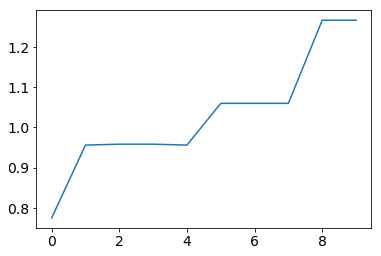

In [54]:
plt.plot(p)

In [225]:
2/3

0.6666666666666666

## Test results

In [9]:
def get_reference_data():
    unsubstituted = MrccCalculator.get_total_energy('data/coronene-dimer/mrcc-fast/QM/order-0/site-all-cc') - 2* MrccCalculator.get_total_energy('data/coronene-dimer/mrcc-monomer-fast/QM/order-0/site-all-cc')
    def _get_nn_energy(folder):
        base = MrccCalculator.get_total_energy(folder)
        lines = open('%s/run.log' % folder).readlines()
        if len([_ for _ in lines if 'NOT CONVERGED'  in _]) > 0:
            raise ValueError()
        try:
            included = [float(_.strip().split()[-1]) for _ in lines if _.startswith(' Nuclear repulsion energy')][0]
            should = [float(_.strip().split()[-1]) for _ in lines if _.startswith(' Nuclear repulsion with point charges')][0]
        except:
            raise
        return base - included + should
        
    def _ref_energy(Afolder):
        A = _get_nn_energy(Afolder)
        AB = _get_nn_energy(Afolder + 'B')
        B = _get_nn_energy('data/coronene-dimer/mrcc-monomer-fast/QM/order-0/site-all-cc')
        
        return AB-A-B
    def _pred_energy(Afolder):
        dZ = read_dZ_from_input('%s/run.inp' % Afolder)
        return predict(dZ)[0]
    
    res = []
    for case in range(1, 13):
        for mode in 'MIN MAX'.split():
            for rank in range(10):
                try:
                    Afolder = 'data/validation-new/%d-%s-%d-A' % (case, mode, rank)
                    interaction_ref = _ref_energy(Afolder) 
                    interaction_pred = _pred_energy(Afolder) + unsubstituted
                except:
                    continue
                res.append({'pairs': case, 'mode': mode, 'interaction_ref': interaction_ref, 'interaction_pred': interaction_pred, 'rank': rank})
        #for mode in 'MIN MAX'.split():
        #    for rank in range(10):
        #        try:
        #            Afolder = 'data/ga-search-2/random/%d-%s-%d-A' % (case, mode, rank)
        #            interaction_ref = _ref_energy(Afolder) - unsubstituted
        #            interaction_pred = _pred_energy(Afolder)
        #        except FileNotFoundError:
        #            continue
        #        res.append({'pairs': case, 'mode': 'RAND', 'interaction_ref': interaction_ref, 'interaction_pred': interaction_pred, 'rank': rank})
    res = pd.DataFrame(res)
    #res = res[abs(res.interaction_ref.values) < 20]
    return res
def read_dZ_from_input(infile):
    dZ = []
    with open(infile) as fh:
        lines = [_.strip() for _ in fh.readlines()]
    started = lines.index('qmmm=Amber')

    for line in lines[started+3:]:
        dZ.append(int(float(line.split()[-1])))
    return dZ[:24]
res = get_reference_data()

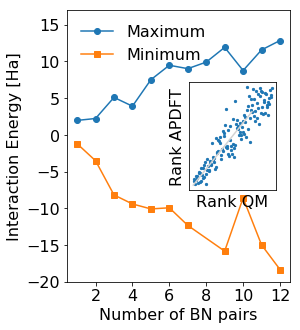

In [23]:
plt.rc('font', size=16)
f, axmain = plt.subplots(figsize=(4, 5))
#unsubstituted = MrccCalculator.get_total_energy('data/coronene-dimer/mrcc-fast/QM/order-0/site-all-cc') - 2* MrccCalculator.get_total_energy('data/coronene-dimer/mrcc-monomer-fast/QM/order-0/site-all-cc')

s = res.query('mode == "MAX" and abs(interaction_ref) <20 ').groupby('pairs').max().reset_index()
axmain.plot(s.pairs, s.interaction_ref, 'o-', label='Maximum')
s = res.query('mode == "MIN" and abs(interaction_ref) <20 ').groupby('pairs').min().reset_index()
axmain.plot(s.pairs, s.interaction_ref, 's-',  label='Minimum')

axmain.set_xticks((2, 4, 6, 8, 10, 12))
axmain.set_xticklabels((2, 4, 6, 8, 10, 12))

left, bottom, width, height = [0.55, 0.38, 0.3, 0.3]
inset = f.add_axes([left, bottom, width, height])

group = res.query('abs(interaction_ref) <20 ')
p = group.interaction_pred.rank(method='first')
r = group.interaction_ref.rank(method='first')
inset.scatter(r, p, s=5)
inset.plot((0, 100), (0, 100), color='lightgrey')
inset.set_xlabel('Rank QM')
inset.set_ylabel('Rank APDFT')
inset.set_xticks([])
inset.set_yticks([])

axmain.set_ylim(-20, 17)
axmain.legend(frameon=False, loc='upper left')
axmain.set_ylabel('Interaction Energy [Ha]')
axmain.set_xlabel('Number of BN pairs')
plt.savefig('coronene-dimer-energies.pdf', bbox_inches='tight')

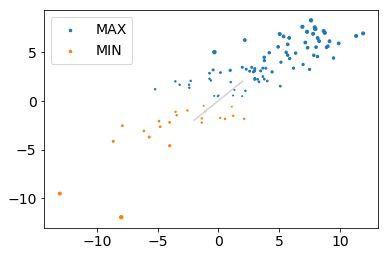

In [171]:
#res.query('mode == "MIN"').groupby('pairs').min()
for name, group in res.query('abs(interaction_ref) <20 ').groupby('mode'):
    plt.scatter(group.interaction_ref, group.interaction_pred*4, label=name, s=group.pairs)
plt.legend()
#plt.xlim(-2, 2)
#plt.ylim(-2, 2)
plt.plot((-2, 2), (-2, 2), color='lightgrey')

MAX 0.7755716239984366


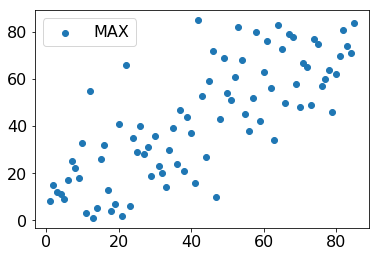

MIN 0.8741836734693876


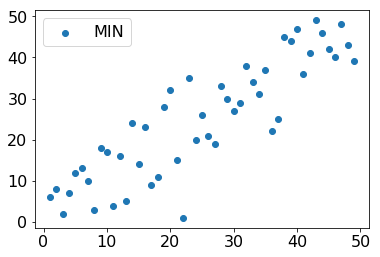

In [21]:
from scipy.stats import spearmanr
for name, group in res.query('abs(interaction_ref) <20 ').groupby('mode'.split()):
    print (name, spearmanr(group.interaction_pred.values, group.interaction_ref.values).correlation)
    p = group.interaction_pred.rank(method='first')
    r = group.interaction_ref.rank(method='first')
    plt.scatter(r, p, label=name)
    plt.legend()
    plt.show()

MIN 0.9229716081247896


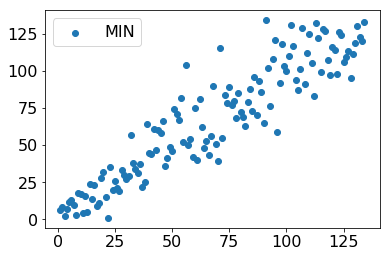

In [22]:
from scipy.stats import spearmanr
group = res.query('abs(interaction_ref) <20 ')
print (name, spearmanr(group.interaction_pred.values, group.interaction_ref.values).correlation)
p = group.interaction_pred.rank(method='first')
r = group.interaction_ref.rank(method='first')
plt.scatter(r, p, label=name)
plt.legend()
plt.show()

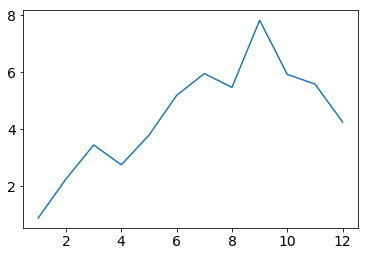

In [174]:
res['error'] = abs(res.interaction_pred.values - res.interaction_ref.values)
s = res.query('abs(interaction_ref) <20 ').groupby('pairs').mean()['error'].reset_index()
plt.plot(s.pairs, s.error)

In [212]:
unsubstituted = MrccCalculator.get_total_energy('data/coronene-dimer/mrcc-fast/QM/order-0/site-all-cc') - 2* MrccCalculator.get_total_energy('data/coronene-dimer/mrcc-monomer-fast/QM/order-0/site-all-cc')
-1849.9094727335977950-(-928.5695159066144697+-921.8062627933904878)-unsubstituted

0.43294046724440705

In [218]:
q = nuclear_charges_part.copy()
q[includeonly_part] += np.array(read_dZ_from_input('data/ga-search-2/validation/2-MIN-0-A/run.inp'))
print (ap.Coulomb.nuclei_nuclei(coordinates_whole, list(q) + list(q*0)))


1836.7959175114895


In [224]:
coordinates_part - coordinates_whole[:36,:]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [230]:
-1863.0706400754243077--1849.9094727335977950

-13.161167341826513

In [231]:
-945.8965357793967996--928.5695159066144697

-17.32701987278233

In [25]:
res.sort_values('interaction_ref')

,interaction_pred,interaction_ref,mode,pairs,rank
100,-2.218762,-178.013831,MIN,8,0
101,-2.210872,-164.210091,MIN,8,1
127,-2.647162,-21.961793,MIN,11,9
135,-2.668945,-18.326764,MIN,12,6
111,-2.235402,-15.825901,MIN,9,8
126,-2.762299,-14.977204,MIN,11,1
110,-2.378612,-13.041551,MIN,9,2
91,-1.880475,-12.321035,MIN,7,5
93,-1.834223,-11.773395,MIN,7,9
90,-1.949572,-10.713531,MIN,7,0


In [134]:
-951.0645915491968481 - 1837.330606493059 + 1839.873812626097, -1872.9327992023227125 - 6088.170020716419+6102.116604114562

(-948.5213854161586, -1858.9862158041797)

In [135]:
1858.9862158041797 - 948.5213854161586 - 921.8062627933904878

-11.34143240536946

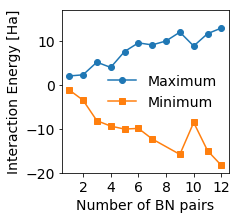

In [14]:
plt.rc('font', size=14)
f, axmain = plt.subplots(figsize=(3, 3))
#unsubstituted = MrccCalculator.get_total_energy('data/coronene-dimer/mrcc-fast/QM/order-0/site-all-cc') - 2* MrccCalculator.get_total_energy('data/coronene-dimer/mrcc-monomer-fast/QM/order-0/site-all-cc')

s = res.query('mode == "MAX" and abs(interaction_ref) <20 ').groupby('pairs').max().reset_index()
axmain.plot(s.pairs, s.interaction_ref, 'o-', label='Maximum')
s = res.query('mode == "MIN" and abs(interaction_ref) <20 ').groupby('pairs').min().reset_index()
axmain.plot(s.pairs, s.interaction_ref, 's-',  label='Minimum')

axmain.set_xticks((2, 4, 6, 8, 10, 12))
axmain.set_xticklabels((2, 4, 6, 8, 10, 12))

#left, bottom, width, height = [0.55, 0.38, 0.3, 0.3]
#inset = f.add_axes([left, bottom, width, height])

#group = res.query('abs(interaction_ref) <20 ')
#p = group.interaction_pred.rank(method='first')
#r = group.interaction_ref.rank(method='first')
#inset.scatter(r, p, s=5)
#inset.plot((0, 100), (0, 100), color='lightgrey')
#inset.set_xlabel('Rank QM')
#inset.set_ylabel('Rank APDFT')
#inset.set_xticks([])
#inset.set_yticks([])

axmain.set_ylim(-20, 17)
axmain.legend(frameon=False, loc='best')
axmain.set_ylabel('Interaction Energy [Ha]')
axmain.set_xlabel('Number of BN pairs')
plt.savefig('coronene-pairs.pdf', bbox_inches='tight')

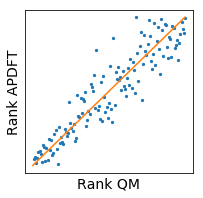

In [23]:
plt.rc('font', size=14)
f, axmain = plt.subplots(figsize=(3, 3))
#unsubstituted = MrccCalculator.get_total_energy('data/coronene-dimer/mrcc-fast/QM/order-0/site-all-cc') - 2* MrccCalculator.get_total_energy('data/coronene-dimer/mrcc-monomer-fast/QM/order-0/site-all-cc')


#left, bottom, width, height = [0.55, 0.38, 0.3, 0.3]
inset = axmain

group = res.query('abs(interaction_ref) <20 ')
p = group.interaction_pred.rank(method='first')
r = group.interaction_ref.rank(method='first')
inset.scatter(r, p, s=5)
inset.plot((0, len(group)), (0, len(group)), color='C1')
inset.set_xlabel('Rank QM')
inset.set_ylabel('Rank APDFT')
inset.set_xticks([])
inset.set_yticks([])

plt.savefig('coronene-ranks.pdf', bbox_inches='tight')